In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/HandWritten/HandwrittenDataset

/content/drive/MyDrive/HandWritten/HandwrittenDataset


In [3]:
#importing libraries
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121

In [4]:
def create_dataframe_digits(data_path):
    class_categories = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        '6': 6,
        '7': 7,
        '8': 8,
        '9': 9,
    }
    image_paths = []
    image_outputs = []
    for category, output in class_categories.items():
        folder_path = os.path.join(data_path, category)      # data_path/category/
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            image_paths.append(image_path)
            image_outputs.append(output)
    df = pd.DataFrame({
        'path': image_paths,
        'output': image_outputs
    })
    return df

In [5]:
DATA_PATH='/content/drive/MyDrive/HandWritten/HandwrittenDataset'
train_df=create_dataframe_digits(os.path.join(DATA_PATH,'digits_train_set'))
test_df=create_dataframe_digits(os.path.join(DATA_PATH,'digits_test_set'))


In [6]:
IMG_DIM=128
def imread(img_path):
    img = cv2.imread(img_path)
    img = img.astype('float32')/255.0
    img = cv2.resize(img, (IMG_DIM, IMG_DIM))
    return img


In [7]:
def read_images(img_paths):
    n = len(img_paths)
    X = np.zeros((n, IMG_DIM, IMG_DIM, 3), dtype='float32')
    for i in tqdm(range(n)):
        path = img_paths[i]
        img = imread(path)
        X[i] = img
    return X

In [8]:
x_train=read_images(train_df['path'])
y_train=train_df['output']
x_test=read_images(test_df['path'])
y_test=test_df['output']


100%|██████████| 1414/1414 [04:06<00:00,  5.73it/s]


In [9]:
# Load the pre-trained DenseNet121 model
densenet121 = DenseNet121(include_top=False, input_shape=(IMG_DIM, IMG_DIM, 3), pooling='avg')

29084464/29084464 [==============================] - 0s 0us/step


In [10]:
# Freeze the weights of the DenseNet121 layers
for layer in densenet121.layers:
    layer.trainable = False

In [11]:
# Create a new model that includes the DenseNet121 layers followed by some additional layers
model = tf.keras.models.Sequential()
model.add(densenet121)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # diff between actual and probabilities
              metrics=['accuracy'])


In [14]:
# Train the model
model.fit(x_train, y_train, epochs=50) # less epochs means UF , more epochs means OF

Epoch 1/50
207/207 [==============================] - 7s 36ms/step - loss: 0.2445 - accuracy: 0.9223
Epoch 2/50
207/207 [==============================] - 9s 42ms/step - loss: 0.2113 - accuracy: 0.9305
Epoch 3/50
207/207 [==============================] - 7s 35ms/step - loss: 0.1882 - accuracy: 0.9363
Epoch 4/50
207/207 [==============================] - 7s 34ms/step - loss: 0.1777 - accuracy: 0.9440
Epoch 5/50
207/207 [==============================] - 8s 38ms/step - loss: 0.1668 - accuracy: 0.9444
Epoch 6/50
207/207 [==============================] - 7s 34ms/step - loss: 0.1439 - accuracy: 0.9526
Epoch 7/50
207/207 [==============================] - 7s 35ms/step - loss: 0.1319 - accuracy: 0.9569
Epoch 8/50
207/207 [==============================] - 7s 36ms/step - loss: 0.1263 - accuracy: 0.9603
Epoch 9/50
207/207 [==============================] - 7s 34ms/step - loss: 0.1238 - accuracy: 0.9593
Epoch 10/50
207/207 [==============================] - 7s 36ms/step - loss: 0.1148 - accura

In [15]:
# Save the model
model.save('handwritten.model')

In [16]:
# Load the model and evaluate it on the test set
model = tf.keras.models.load_model('handwritten.model')
test_loss, test_acc = model.evaluate(x_test, y_test)

45/45 [==============================] - 6s 62ms/step - loss: 0.1236 - accuracy: 0.9696


In [17]:
print('Test accuracy:', test_acc)

Test accuracy: 0.9695898294448853


In [18]:
# Make predictions on the test set and display some sample images with their predicted labels
y_pred = model.predict(x_test)
code = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}

45/45 [==============================] - 4s 31ms/step


In [19]:
def getcode(n):
    for x, y in code.items():
        if n == y:
            return x


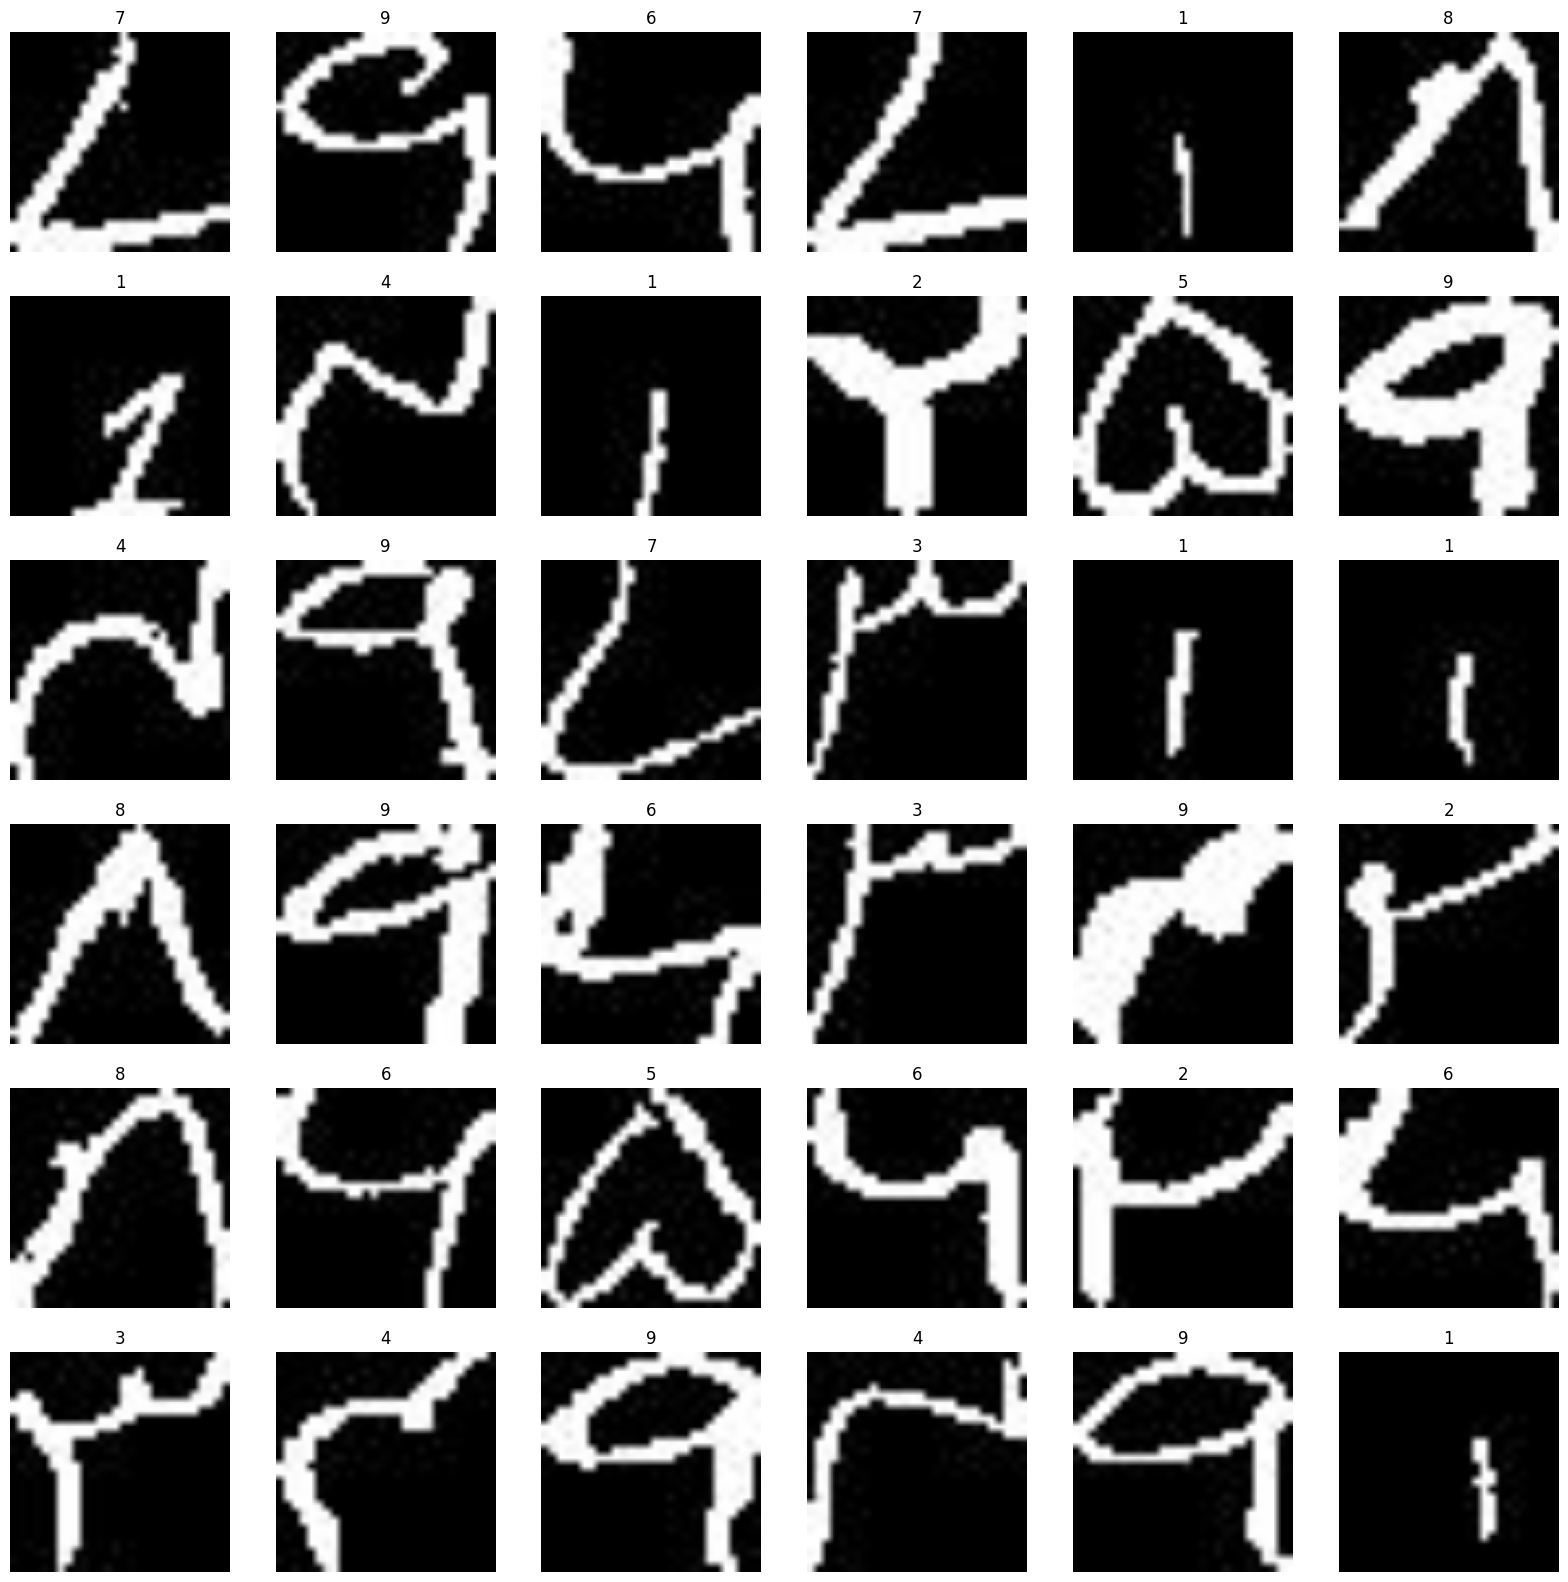

In [20]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(x_test), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title(getcode(np.argmax(y_pred[i])))